In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

In [2]:
data_dir = './multi-output-classification/dataset'

In [3]:
data_root = pathlib.Path(data_dir)

In [4]:
data_root

WindowsPath('multi-output-classification/dataset')

In [5]:
for item in data_root.iterdir():
    print(item)

multi-output-classification\dataset\black_jeans
multi-output-classification\dataset\black_shoes
multi-output-classification\dataset\blue_dress
multi-output-classification\dataset\blue_jeans
multi-output-classification\dataset\blue_shirt
multi-output-classification\dataset\red_dress
multi-output-classification\dataset\red_shirt


In [6]:
all_image_paths = list(data_root.glob('*/*'))

In [7]:
image_count = len(all_image_paths)
image_count

2525

In [8]:
all_image_paths[:3]

[WindowsPath('multi-output-classification/dataset/black_jeans/00000000.jpg'),
 WindowsPath('multi-output-classification/dataset/black_jeans/00000001.jpeg'),
 WindowsPath('multi-output-classification/dataset/black_jeans/00000002.jpeg')]

In [9]:
all_image_paths[-3:]

[WindowsPath('multi-output-classification/dataset/red_shirt/00000383.jpg'),
 WindowsPath('multi-output-classification/dataset/red_shirt/00000386.jpeg'),
 WindowsPath('multi-output-classification/dataset/red_shirt/00000388.jpg')]

In [10]:
# 将图片乱序
import random
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

In [11]:
all_image_paths[:5]

['multi-output-classification\\dataset\\red_shirt\\00000197.jpg',
 'multi-output-classification\\dataset\\red_shirt\\00000179.jpeg',
 'multi-output-classification\\dataset\\black_shoes\\00000086.jpg',
 'multi-output-classification\\dataset\\red_shirt\\00000019.png',
 'multi-output-classification\\dataset\\red_dress\\00000107.jpg']

In [12]:
# 从文件路径中获取对应的label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['black_jeans',
 'black_shoes',
 'blue_dress',
 'blue_jeans',
 'blue_shirt',
 'red_dress',
 'red_shirt']

In [13]:
# 将两个label拆分
color_label_names = set(name.split('_')[0] for name in label_names)
color_label_names

{'black', 'blue', 'red'}

In [14]:
item_label_names = set(name.split('_')[1] for name in label_names)
item_label_names

{'dress', 'jeans', 'shirt', 'shoes'}

In [15]:
# 给颜色标签生成索引
color_label_to_index = dict((name,index) for index,name in enumerate(color_label_names))
color_label_to_index

{'black': 0, 'blue': 1, 'red': 2}

In [16]:
item_label_to_index = dict((name,index) for index,name in enumerate(item_label_names))
item_label_to_index

{'dress': 0, 'jeans': 1, 'shirt': 2, 'shoes': 3}

In [17]:
# 提取图片标签
all_image_labels = [pathlib.Path(path).parent.name for path in all_image_paths]
all_image_labels[:5]

['red_shirt', 'red_shirt', 'black_shoes', 'red_shirt', 'red_dress']

In [18]:
# 拆分标签并将标签转为对应编码
color_labels = [color_label_to_index[label.split('_')[0]] for label in all_image_labels]

In [19]:
color_labels[:5]

[2, 2, 0, 2, 2]

In [20]:
item_labels = [item_label_to_index[label.split('_')[1]] for label in all_image_labels]

In [21]:
item_labels[:5]

[2, 2, 3, 2, 0]

In [22]:
import IPython.display as display

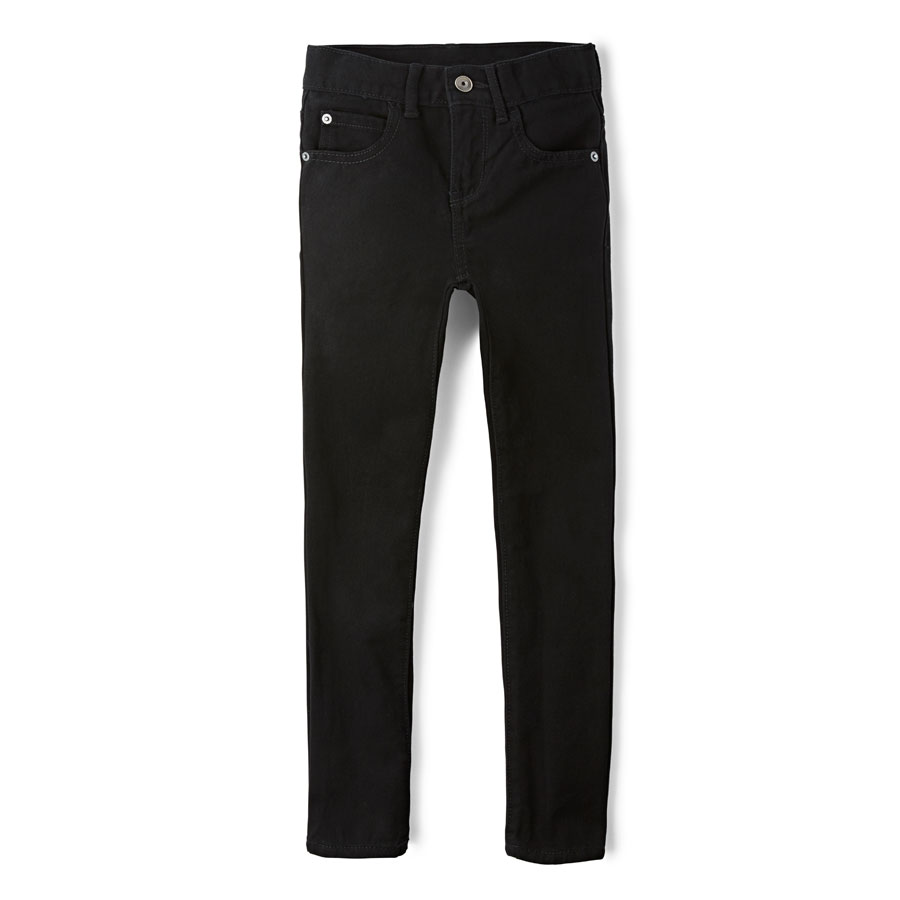

black_jeans


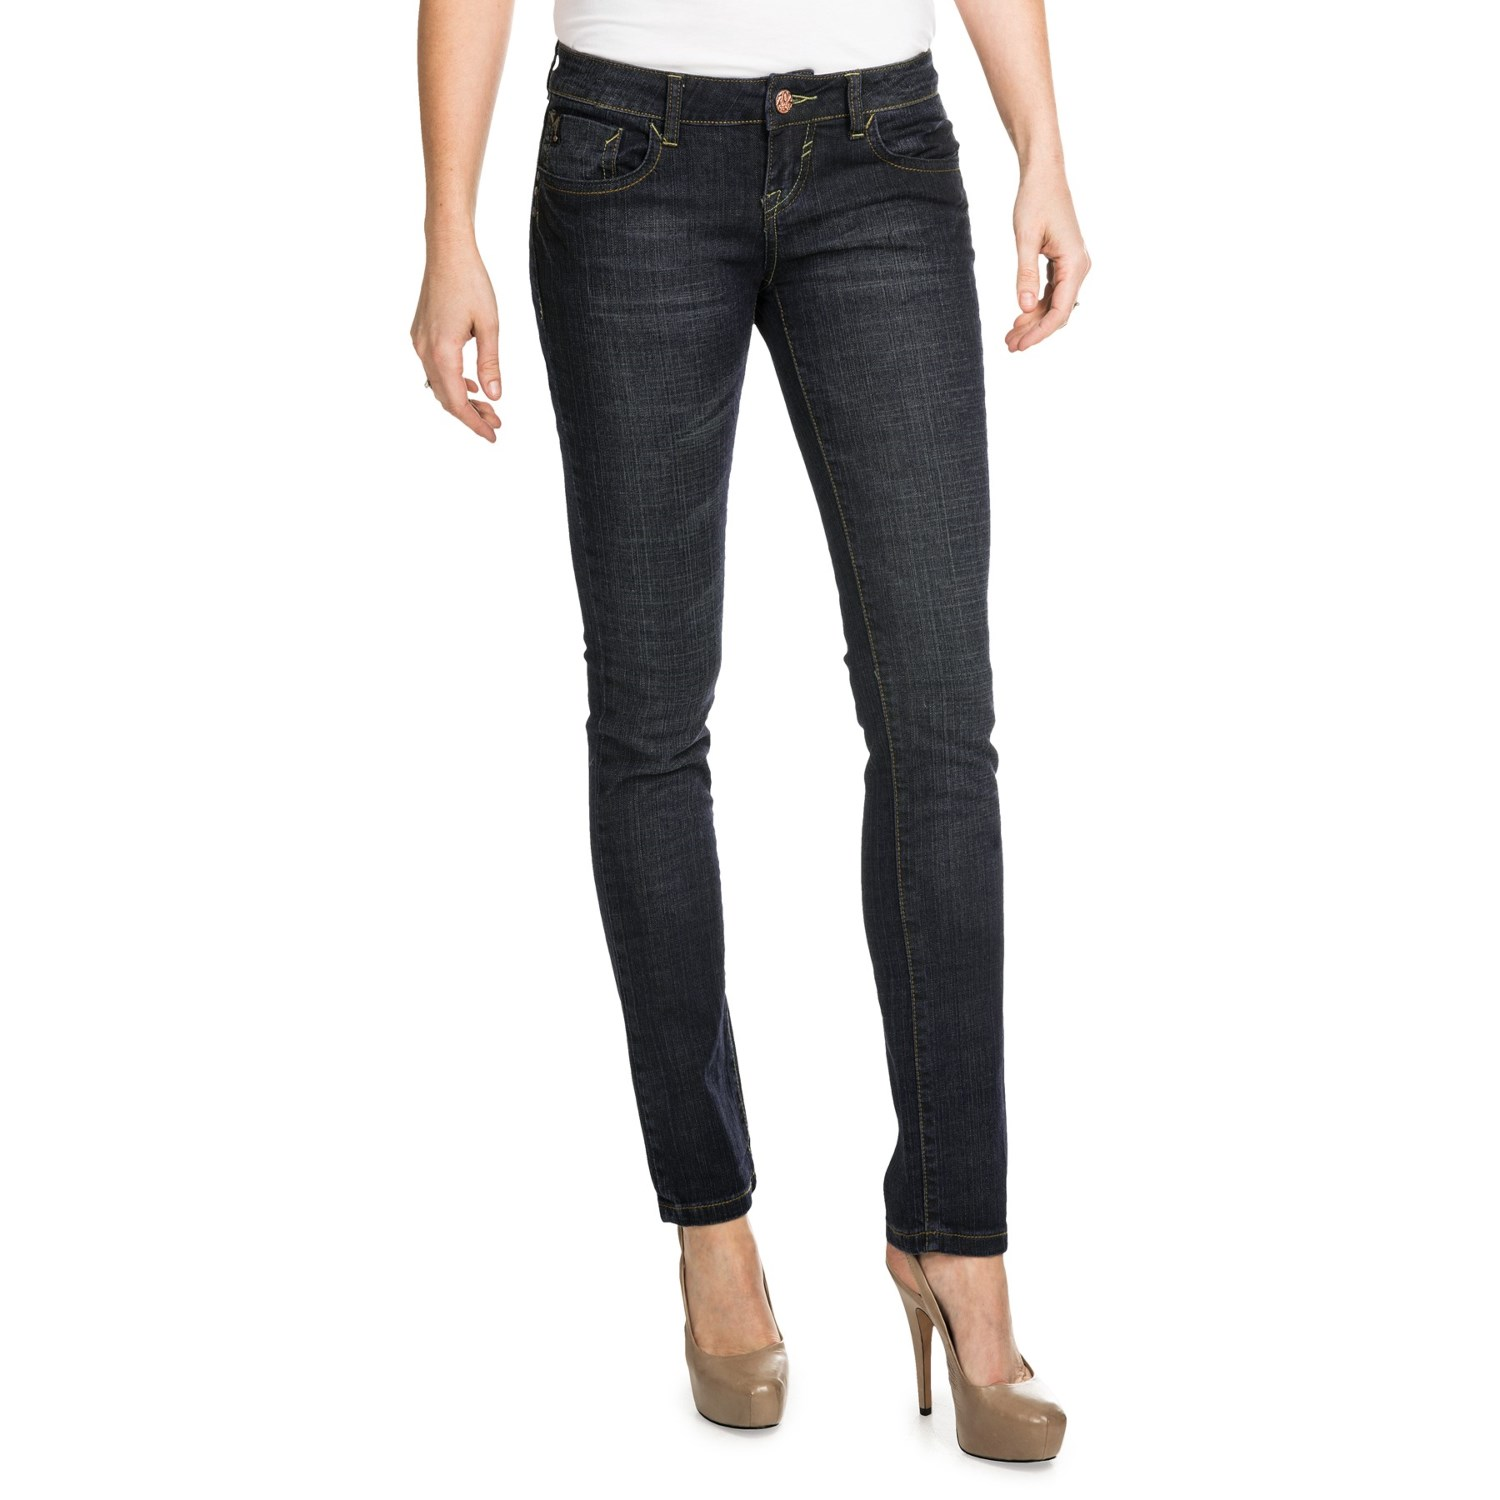

black_jeans


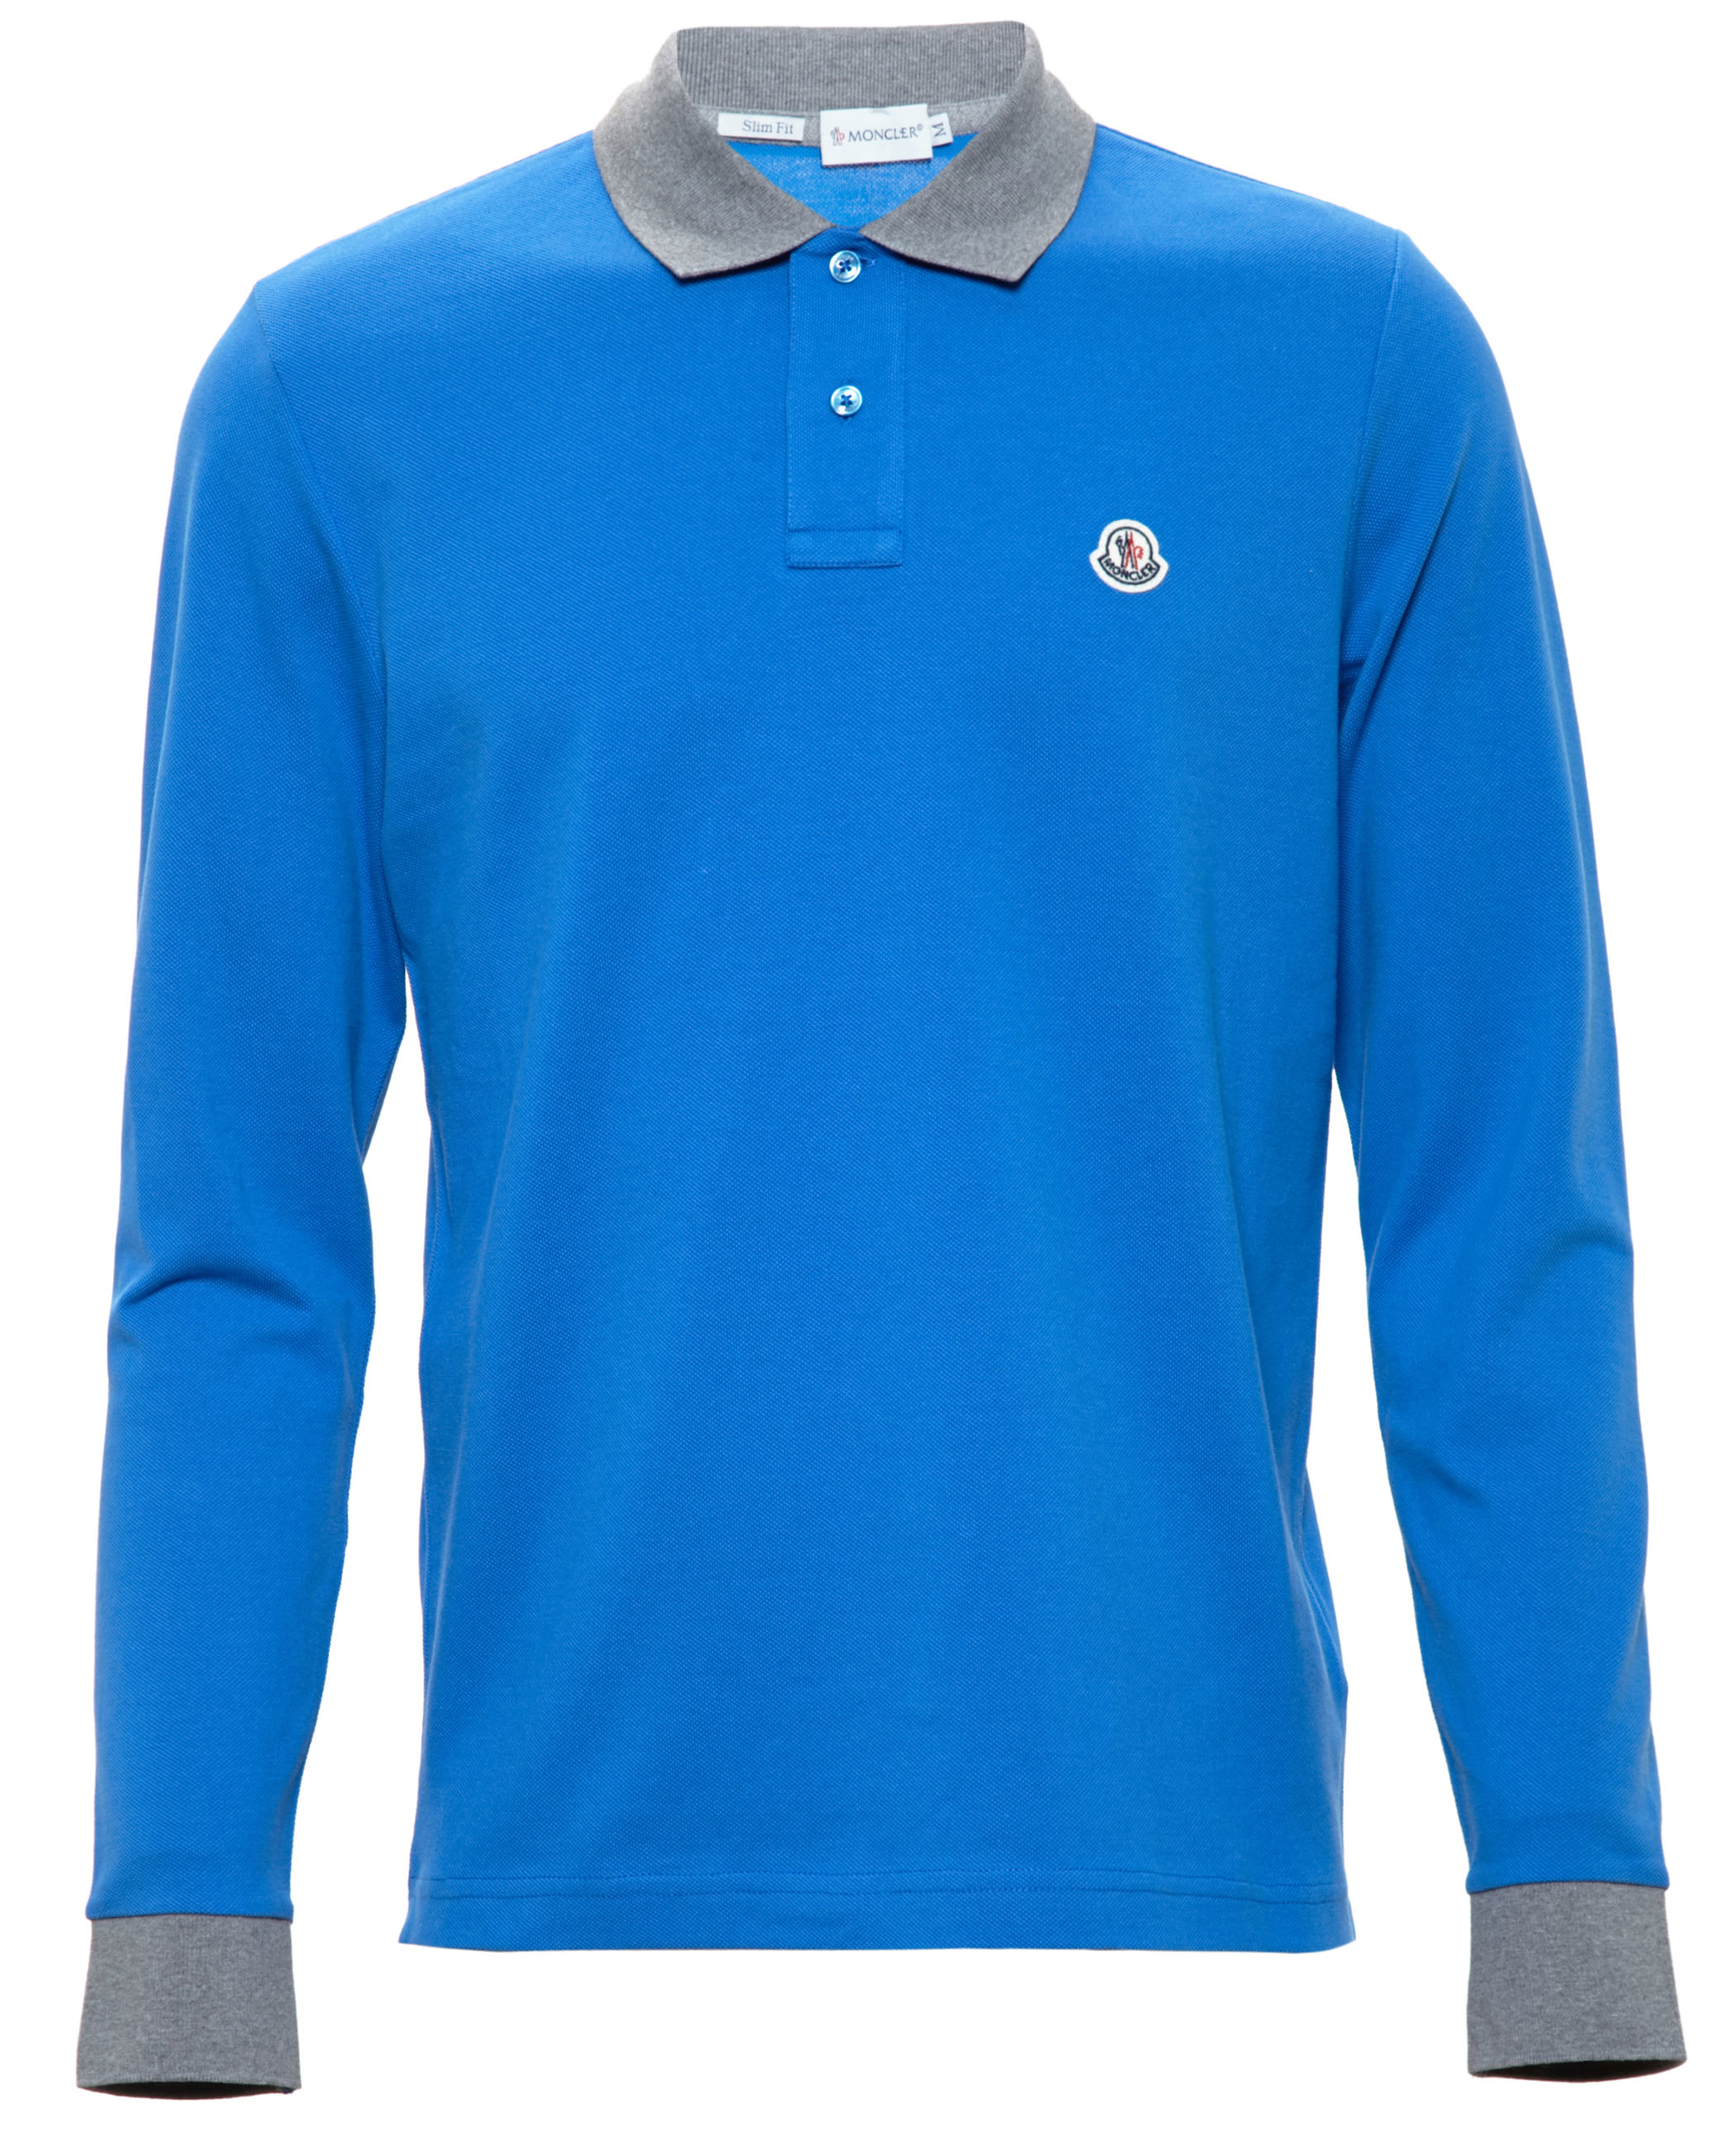

blue_shirt


In [57]:
for n in range(3):
    image_index = random.choice(range(len(all_image_paths)))
    display.display(display.Image(all_image_paths[image_index],width=100,height=100))
    print(all_image_labels[image_index])

加载和格式化图像

In [24]:
img_path = all_image_paths[0]
img_path

'multi-output-classification\\dataset\\red_shirt\\00000197.jpg'

In [25]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe1\x187Exif\x00\x00MM\x00*\x00\x00\x00\x08...


In [26]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(1002, 728, 3)
<dtype: 'uint8'>


In [27]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[224,224])
    image = tf.cast(image,tf.float32)
    image = image/255.0
    image = 2*image - 1
    return image

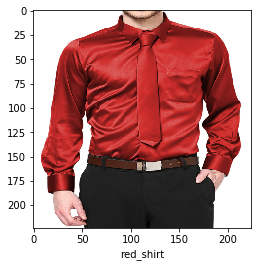

In [28]:
label = all_image_labels[0]
plt.imshow((load_and_preprocess_image(img_path) + 1)/2)
plt.grid(False)
plt.xlabel(label)
print()

In [29]:
# 创建路径dataset
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

In [31]:
# 创建标签dataset
label_ds = tf.data.Dataset.from_tensor_slices((color_labels,item_labels))

In [32]:
for ele in label_ds.take(3):
    print(ele[0].numpy(),ele[1].numpy())

2 2
2 2
0 3


In [33]:
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))

In [34]:
image_label_ds

<ZipDataset shapes: ((224, 224, 3), ((), ())), types: (tf.float32, (tf.int32, tf.int32))>

In [35]:
# 划分train数据集和test数据集
test_count = int(image_count *0.2)
train_count = image_count - test_count

In [36]:
train_data = image_label_ds.skip(test_count)
test_data = image_label_ds.take(test_count)

In [37]:
BATCH_SIZE= 32

In [38]:
train_data = train_data.shuffle(buffer_size=train_count).repeat(-1)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>

In [39]:
test_data = test_data.batch(BATCH_SIZE)

## 建立模型

In [40]:
# 初始化预训练网络mobilenet，不包含预训练网络头部，只使用网络架构，不使用权重
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False)

In [41]:
inputs = tf.keras.Input(shape=(224,224,3))

In [42]:
x = mobile_net(inputs)

In [43]:
x.get_shape()

TensorShape([None, 7, 7, 1280])

In [44]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [45]:
x.get_shape()

TensorShape([None, 1280])

In [46]:
x1 = tf.keras.layers.Dense(1024,activation='relu')(x)
output_color = tf.keras.layers.Dense(len(color_label_names),activation='softmax',name='output_color')(x1)

In [47]:
x2 = tf.keras.layers.Dense(1024,activation='relu')(x)
output_item = tf.keras.layers.Dense(len(item_label_names),activation='softmax',name='output_item')(x2)

In [48]:
model = tf.keras.Model(inputs=inputs,
                       outputs=[output_color,output_item])

In [49]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         1311744     global_average_pooling2d[0][0]   
_______________________________________________________________________________________

## 多输出模型的编译和配置

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
             loss={'output_color':'sparse_categorical_crossentropy',
                   'output_item':'sparse_categorical_crossentropy'},
             metrics=['acc']
             )

In [51]:
train_steps = train_count//BATCH_SIZE
test_steps = test_count//BATCH_SIZE

In [52]:
history = model.fit(train_data,
                    epochs=4,
                    steps_per_epoch=train_steps,
                    validation_data=test_data,
                    validation_steps=test_steps)

Epoch 1/4
63/63 [==============================] - 886s 14s/step - loss: 0.4380 - output_color_loss: 0.2122 - output_item_loss: 0.2259 - output_color_acc: 0.9251 - output_item_acc: 0.9291 - val_loss: 0.5378 - val_output_color_loss: 0.4767 - val_output_item_loss: 0.0611 - val_output_color_acc: 0.7708 - val_output_item_acc: 0.9792
Epoch 2/4
63/63 [==============================] - 754s 12s/step - loss: 0.0433 - output_color_loss: 0.0270 - output_item_loss: 0.0162 - output_color_acc: 0.9940 - output_item_acc: 0.9960 - val_loss: 0.4129 - val_output_color_loss: 0.3729 - val_output_item_loss: 0.0400 - val_output_color_acc: 0.8458 - val_output_item_acc: 0.9896
Epoch 3/4
63/63 [==============================] - 741s 12s/step - loss: 0.0259 - output_color_loss: 0.0132 - output_item_loss: 0.0128 - output_color_acc: 0.9960 - output_item_acc: 0.9970 - val_loss: 0.1783 - val_output_color_loss: 0.1421 - val_output_item_loss: 0.0362 - val_output_color_acc: 0.9375 - val_output_item_acc: 0.9875
Epoch 4

## 模型评价

In [56]:
model.evaluate(test_data,label_ds)

ValueError: `y` argument is not supported when using dataset as input.